In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from functools import partial

np.random.seed(1729)
plt.rcParams['figure.figsize'] = 15, 8

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Planing horizon
h = 12
s = 0

# forecasts for a year from HW №2
forecast = [297.20766224157813, 300.69163028120994, 282.51326873326303, 257.783521578908, 250.26309804642202, 240.1651449636221,
            247.47719728291037, 238.53373182845115, 233.52362023317815, 244.53669488012792, 256.05582680642607, 272.0632615669966]
a = 233 # min forecast
b = 301 # max forecast

storage_limitation = int(a/2)
storage_limitation

116

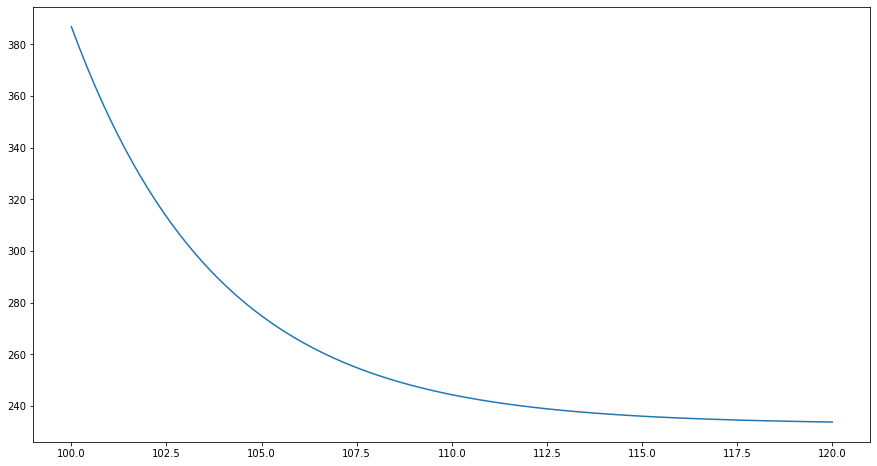

In [3]:
# some helper functions:
def elasticity_func(x):
    return b * np.exp(-0.26 * x) * 1e11 + a

def revenue(p):
    return p * elasticity_func(p)

def obj(x):
    storage_cost = 0
    stored_capacity = 0
    for produced, sold in zip(forecast, elasticity_func(x)):
        stored_capacity += produced - sold
        storage_cost += inventory(stored_capacity)
    
    return storage_cost - sum([revenue(i) for i in x])

# Sales function
def sales_function(x):
    return sum([elasticity_func(i) for i in x])

price = np.linspace(100, 120, 100)
plt.plot(price, elasticity_func(price))


inventory function to calculate the cost


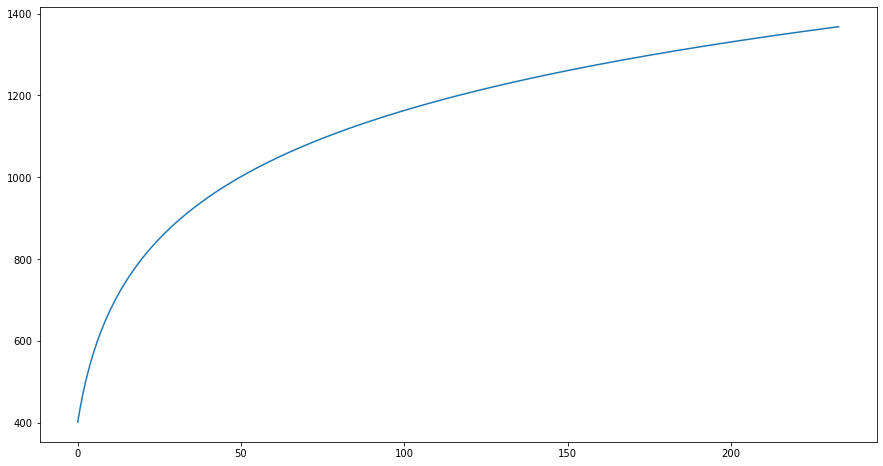

In [4]:
def inventory(x):
    return 250 * np.log(x + 5)

inv_level = np.linspace(0, a, b)
plt.plot(inv_level, inventory(inv_level))

### ACTUAL SOLUTION


In [5]:
def condition_sales(x, i_max=0):
    return sum(forecast[:i_max + 1]) - sum(elasticity_func(x[:i_max + 1]))

def conditions_storage(x, i_max=0):
    return sum(elasticity_func(x[:i_max + 1])) - sum(forecast[:i_max + 1]) + storage_limitation

In [6]:
def solve(forecast, storage_limitation=False):
    """
    finds the solution to NLP problem
    """
    h = len(forecast)

    x0 = 110 * np.ones(h)
    print('Initial Objective: ' + str(-obj(x0)))

    cons = []
    for i in range(h):
        cons.append({'type': 'ineq', 'fun': partial(condition_sales, i_max=i)})
        if storage_limitation:
            cons.append({'type': 'ineq', 'fun': partial(conditions_storage, i_max=i)})
        
    bounds = [(min(price), max(price)) for _ in range(h)]
    
    solution = minimize(obj, x0, method='SLSQP', bounds=bounds, constraints=cons)
    x = solution.x
    # show final objective
    print('Final Objective (Revenue): ' + str(-obj(x)))


    return x

In [7]:

unlimit_storage_x = solve(forecast, storage_limitation=False)
sell_per_month = [elasticity_func(i) for i in unlimit_storage_x]


Initial Objective: 307671.62402560737
Final Objective (Revenue): 341108.586598104


In [8]:
def test_obj(x, sell_per_month):
    storage_cost = 0
    stored = 0
    for prod, sold in zip(forecast, sell_per_month):
        stored += prod - sold
        storage_cost += inventory(stored)
    
    print(sum([revenue(i) for i in x]))
    print(storage_cost)
    return storage_cost - sum([revenue(i) for i in x])

-test_obj(unlimit_storage_x, sell_per_month)

347813.87378716894
6705.287189064961


341108.586598104

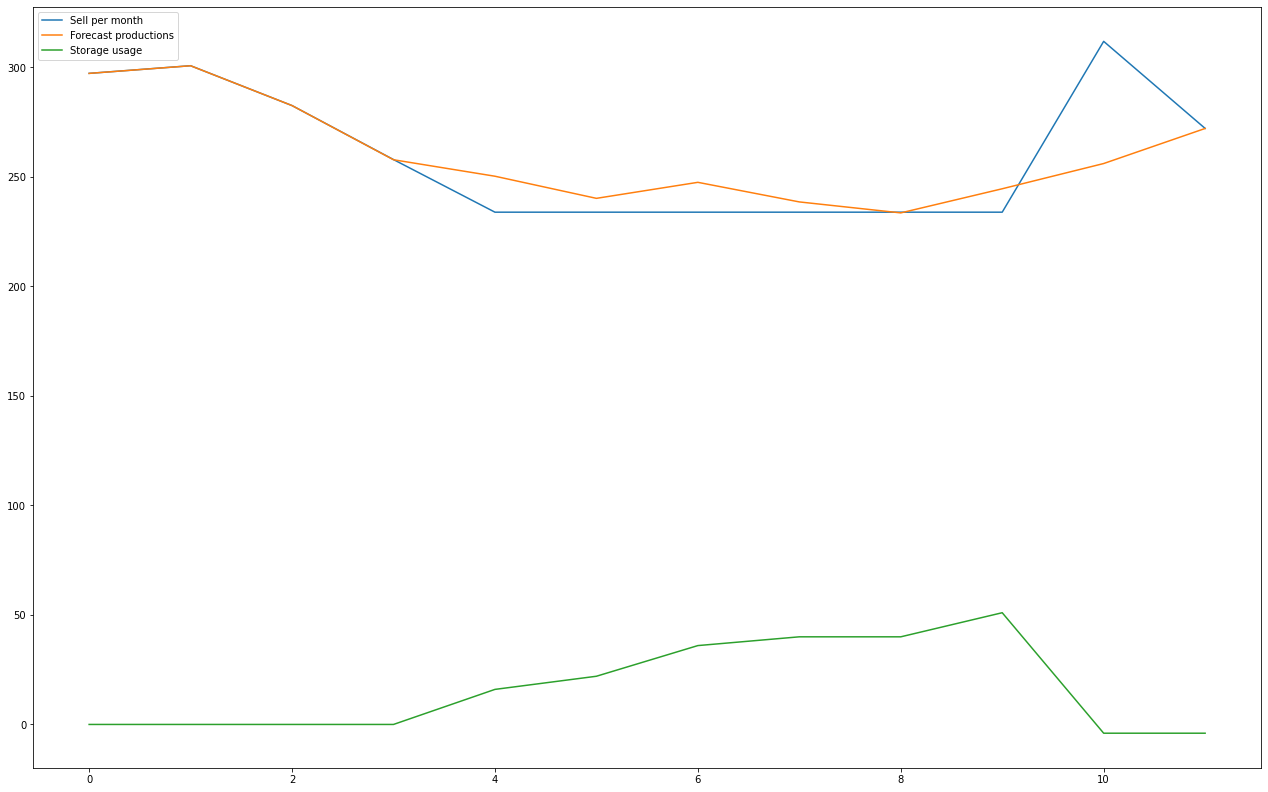

[0, 0, 0, 0, 16, 22, 36, 40, 40, 51, -4, -4]

In [9]:
plt.rcParams['figure.figsize'] = 22, 14

plt.plot(sell_per_month, label="Sell per month")
plt.plot(forecast, label="Forecast productions")

# calculating the storage usage
storage_usage = []
stored = 0
for prod, sold in zip(forecast, sell_per_month):
    stored += prod - sold
    storage_usage.append(int(stored))

plt.plot(storage_usage, label="Storage usage")
plt.legend()
plt.show()
storage_usage

#### From the graph we can see that cumulative sum of sell per month is not greater that cumulative sum of our productions, which says that our estimate is probably valid

### Limiting storage to a // 2:

In [10]:
limited_storage_x = solve(forecast, storage_limitation=True)

Initial Objective: 307671.62402560737
Final Objective (Revenue): 339943.1482303741


In [11]:
# show final objective
print('Final Objective (Revenue): ' + str(-obj(limited_storage_x)))

sell_per_month = [elasticity_func(i) for i in limited_storage_x]
sell_per_month

Final Objective (Revenue): 339943.1482303741


[297.51754523321847,
 301.0401363056335,
 282.60976621558484,
 257.6782940372976,
 233.84835702451687,
 233.84835702451687,
 233.84835702451687,
 233.84835702451687,
 233.84835702451687,
 233.84835702451687,
 307.59693427122176,
 272.5834215702778]

In [12]:
-test_obj(limited_storage_x, sell_per_month)
341108.586598104
339943.1482303741 a//2

347533.268656242
7590.120425867903


339943.1482303741

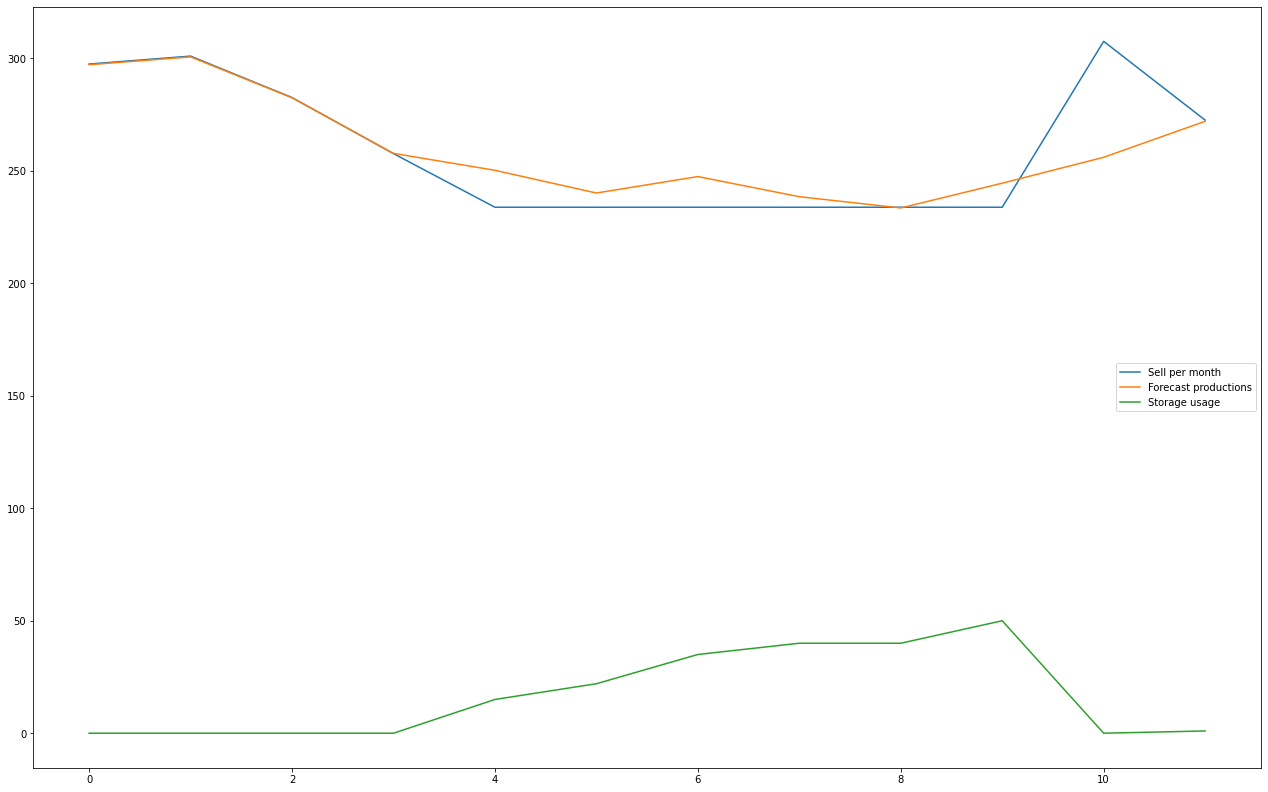

In [13]:
plt.rcParams['figure.figsize'] = 22, 14

plt.plot(sell_per_month, label="Sell per month")
plt.plot(forecast, label="Forecast productions")

# calculating the storage usage
storage_usage = []
stored = 0
for prod, sold in zip(forecast, sell_per_month):
    stored += prod - sold
    storage_usage.append(abs(int(stored)))
storage_usage
plt.plot(storage_usage, label="Storage usage")
plt.legend()
plt.show()

### Conclusion

We can see that limitation on storage didn't change our initial solution with unlimited storage much. Maybe we should decrease the storage limit.